In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install python_speech_features
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from python_speech_features import mfcc
import requests
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=ef890c9c910822f24724f323718e83d54fcfee8576a5483d760fc995a6df2bab
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


In [2]:

# Download and extract RAVDESS dataset
def download_and_extract_ravdess():
    url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"
    response = requests.get(url)
    if response.status_code == 200:
        zip_ref = zipfile.ZipFile(BytesIO(response.content))
        zip_ref.extractall("ravdess_dataset/")
        zip_ref.close()
        print("RAVDESS dataset downloaded and extracted.")
    else:
        print("Failed to download dataset.")

# Ensure dataset is available
data_path = "ravdess_dataset/"
if not os.path.exists(data_path):
    download_and_extract_ravdess()

RAVDESS dataset downloaded and extracted.


In [8]:
# Load dataset path
DATA_PATH = "ravdess_dataset/"

# Emotion Labels in RAVDESS
EMOTIONS = { '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
             '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised' }

import librosa
def extract_features_librosa(file_path, max_pad_len=200):
    signal, rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=40, n_fft=2048, hop_length=512)

    # Check the shape of the extracted MFCC
    num_time_steps = mfccs.shape[1]

    # If MFCC output is shorter than max_pad_len, pad it
    if num_time_steps < max_pad_len:
        pad_width = max_pad_len - num_time_steps
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')

    # If MFCC output is longer, truncate it
    elif num_time_steps > max_pad_len:
        mfccs = mfccs[:, :max_pad_len]

    return mfccs  # Shape will always be (40, 200)


# Process dataset
audio_files = []
labels = []
for subdir, _, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            emotion = EMOTIONS[file.split("-")[2]]
            features = extract_features_librosa(file_path)
            audio_files.append(features)
            labels.append(emotion)

for i, feat in enumerate(audio_files):
    if feat.shape != (40, 200):
        print(f"Issue at index {i}, feature shape: {feat.shape}")

# Convert to NumPy arrays
X = np.stack(audio_files, axis=0).astype(np.float32)
print(f"Shape of X after stacking: {X.shape}")  # Expected shape: (n_samples, 40, 200)

y = np.array(labels)

print(f"Shape of X before split: {X.shape}")  # Expected shape: (n_samples, 200, 40)


# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

#y = one_hot_encode(y, len(EMOTIONS))

# Train-Validation-Test Split
# Step 1: Split into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Split the temporary set into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to Tensors
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Dataset
class SERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets and Loaders
train_dataset = SERDataset(X_train, y_train)
val_dataset = SERDataset(X_val, y_val)
test_dataset = SERDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, Batch y shape: {y_batch.shape}")
    break  # Check one batch only

for inputs, labels in train_loader:
    print(f"Batch inputs shape: {inputs.shape}")  # Expected: (batch_size, 40, 200)
    print(f"Batch labels shape: {labels.shape}")  # Expected: (batch_size,)
    break  # Check one batch only


Shape of X after stacking: (1440, 40, 200)
Shape of X before split: (1440, 40, 200)
Batch X shape: torch.Size([32, 40, 200]), Batch y shape: torch.Size([32])
Batch inputs shape: torch.Size([32, 40, 200])
Batch labels shape: torch.Size([32])


In [10]:
# Define CNN+LSTM Model
class SERModel(nn.Module):
    def __init__(self, num_classes):
        super(SERModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=40, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)  # Shape: (batch_size, 64, 200)
        x = self.pool(x)   # Shape: (batch_size, 64, 100)
        x = x.permute(0, 2, 1)  # Shape: (batch_size, 100, 64) for LSTM
        x, _ = self.lstm(x)  # Shape: (batch_size, 100, 64)
        x = x[:, -1, :]  # Shape: (batch_size, 64)
        x = self.fc1(x)  # Shape: (batch_size, 64)
        x = self.dropout(x)
        x = self.fc2(x)  # Shape: (batch_size, num_classes)
        return x


In [11]:
# Model Initialization
num_classes = len(EMOTIONS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERModel(num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# History to track metrics
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Training Loop with Explicit Validation Phase
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        # Training Phase
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track Training Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track Validation Metrics
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        model.train()


In [12]:
# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_pred_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            # Track Metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probabilities.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print(f"Test Accuracy: {acc * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return y_true, y_pred, np.array(y_pred_proba)


In [13]:
# Plotting Functions
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label="Training Accuracy")
    plt.plot(history['val_acc'], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, labels):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    from itertools import cycle
    y_true_bin = label_binarize(y_true, classes=np.arange(len(labels)))
    n_classes = len(labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve of class {labels[i]} (area = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


In [14]:
# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)

# Evaluate the Model
y_true, y_pred, y_pred_proba = evaluate_model(model, test_loader)



Epoch 1/30, Train Loss: 2.0609, Train Acc: 0.1369, Val Loss: 1.9944, Val Acc: 0.2454
Epoch 2/30, Train Loss: 1.9481, Train Acc: 0.2282, Val Loss: 1.9134, Val Acc: 0.1991
Epoch 3/30, Train Loss: 1.8680, Train Acc: 0.2361, Val Loss: 1.8179, Val Acc: 0.2778
Epoch 4/30, Train Loss: 1.8250, Train Acc: 0.2758, Val Loss: 1.8379, Val Acc: 0.2685
Epoch 5/30, Train Loss: 1.8049, Train Acc: 0.2857, Val Loss: 1.8057, Val Acc: 0.2685
Epoch 6/30, Train Loss: 1.7657, Train Acc: 0.2609, Val Loss: 1.7568, Val Acc: 0.2917
Epoch 7/30, Train Loss: 1.7696, Train Acc: 0.2827, Val Loss: 1.8414, Val Acc: 0.2593
Epoch 8/30, Train Loss: 1.7419, Train Acc: 0.2966, Val Loss: 1.7553, Val Acc: 0.2963
Epoch 9/30, Train Loss: 1.6990, Train Acc: 0.3026, Val Loss: 1.7266, Val Acc: 0.2917
Epoch 10/30, Train Loss: 1.6903, Train Acc: 0.3254, Val Loss: 1.7445, Val Acc: 0.3056
Epoch 11/30, Train Loss: 1.6816, Train Acc: 0.3343, Val Loss: 1.7954, Val Acc: 0.2778
Epoch 12/30, Train Loss: 1.6877, Train Acc: 0.3194, Val Loss: 1

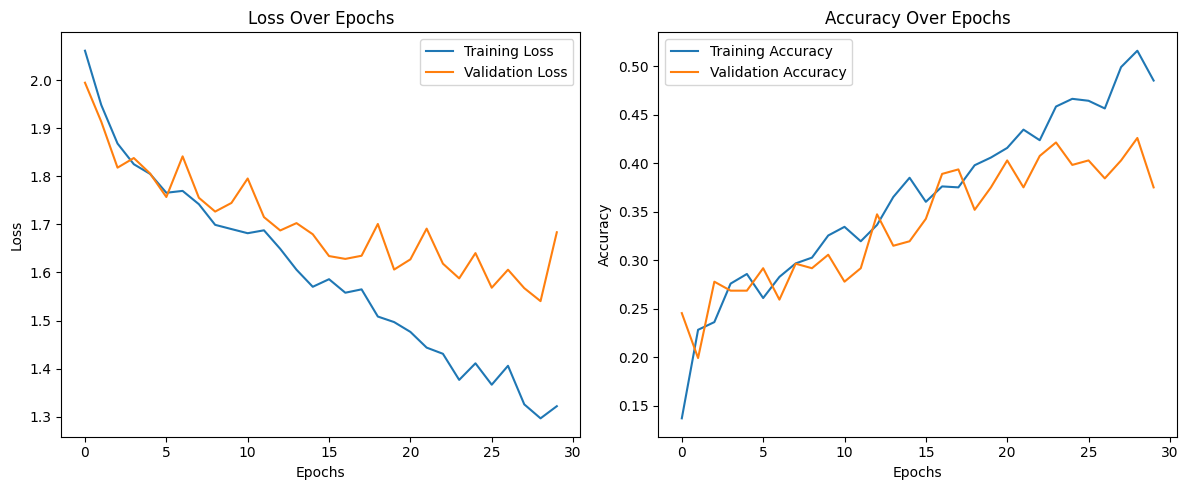

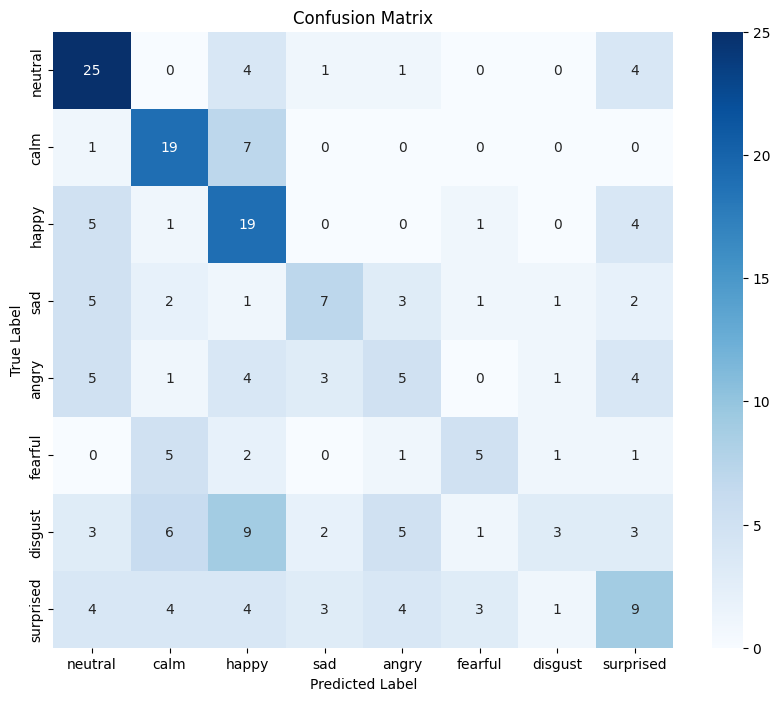

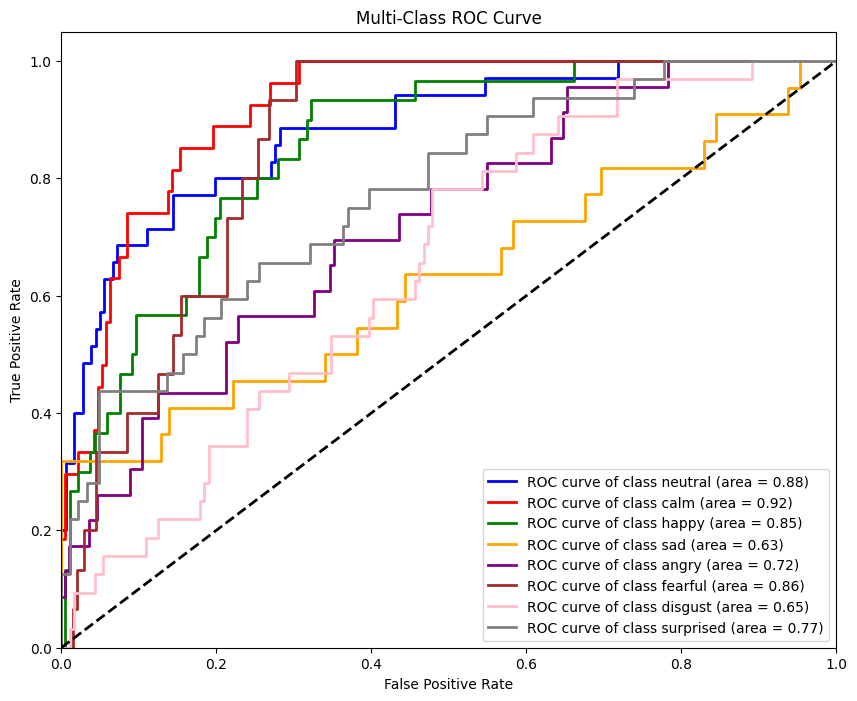

In [15]:
# Plot Results
plot_training_history(history)
plot_confusion_matrix(confusion_matrix(y_true, y_pred), list(EMOTIONS.values()))
plot_roc_curve(y_true, y_pred_proba, list(EMOTIONS.values()))



In [16]:
# Save Model
torch.save(model.state_dict(), "ser_model.pth")

In [3]:
#Improvising
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [4]:
# Multi-Input Model
class SERModelImp(nn.Module):
    def __init__(self, num_classes):
        super(SERModelImp, self).__init__()

        # Branch 1: CNN for Mel-Spectrogram
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Branch 2: Fully Connected Layers for Combined Features
        self.fc_branch = nn.Sequential(
            nn.Linear(59 * 200, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Final Classification Layer
        self.classifier = nn.Sequential(
            nn.Linear(64 * 32 * 50 + 128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, mel_spectrogram, combined_features):
        cnn_output = self.cnn_branch(mel_spectrogram)
        fc_output = self.fc_branch(combined_features.view(combined_features.size(0), -1))
        combined_output = torch.cat((cnn_output, fc_output), dim=1)
        output = self.classifier(combined_output)
        return output

In [5]:
# Dataset Class
class SERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [6]:
# Emotion Labels in RAVDESS
EMOTIONS = { '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
             '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised' }

# Feature Extraction
# Feature extraction function
def extract_combined_features(file_path, max_pad_len=200):
    try:
        # Load audio file
        signal, sr = librosa.load(file_path, sr=None)
        if signal.size == 0:
            print(f"Empty signal for file: {file_path}")
            return None

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40, n_fft=2048, hop_length=512)

        # Extract Chroma
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr, n_fft=2048, hop_length=512)

        # Extract Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=2048, hop_length=512)

        # Extract Mel-Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB scale

        # Pad or truncate all features to a fixed length
        def pad_or_truncate(feature, max_len):
            if feature.shape[1] < max_len:
                pad_width = max_len - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
            elif feature.shape[1] > max_len:
                feature = feature[:, :max_len]
            return feature

        mfccs = pad_or_truncate(mfccs, max_pad_len)
        chroma = pad_or_truncate(chroma, max_pad_len)
        spectral_contrast = pad_or_truncate(spectral_contrast, max_pad_len)
        mel_spectrogram = pad_or_truncate(mel_spectrogram, max_pad_len)

        return {
            'mfccs': mfccs,
            'chroma': chroma,
            'spectral_contrast': spectral_contrast,
            'mel_spectrogram': mel_spectrogram
        }
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None




In [9]:
# Process Dataset
# Ensure dataset is available
data_path = "ravdess_dataset/"

if not os.path.exists(data_path):
    download_and_extract_ravdess()

DATA_PATH = "ravdess_dataset/"
#print(f"Dataset path: {DATA_PATH}")

if not os.path.exists(DATA_PATH):
    raise ValueError("Dataset path does not exist.")

audio_files = []
labels = []
for subdir, _, files in os.walk(DATA_PATH):
    #print(f"Subdirectory: {subdir}")
    #print(f"Files: {[f for f in files if f.endswith('.wav')]}")
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            emotion = EMOTIONS[file.split("-")[2]]
            features = extract_combined_features(file_path)
            if features is not None :  # Only append valid features
                audio_files.append(features)
                labels.append(emotion)

print(f"Number of valid samples: {len(audio_files)}")

#Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convert string labels to integers

# Split into train and test sets
X_mel = np.array([f['mel_spectrogram'] for f in audio_files])
X_mel = X_mel.reshape(X_mel.shape[0], 1, X_mel.shape[1], X_mel.shape[2])  # Add channel dimension
X_mel = torch.tensor(X_mel, dtype=torch.float32)

X_combined = np.array([np.vstack((f['mfccs'], f['chroma'], f['spectral_contrast'])) for f in audio_files])
X_combined = torch.tensor(X_combined, dtype=torch.float32)

X_combined = np.array([np.vstack((f['mfccs'], f['chroma'], f['spectral_contrast'])) for f in audio_files])
X_combined = torch.tensor(X_combined, dtype=torch.float32)

X_train_mel, X_test_mel, X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_mel, X_combined, y, test_size=0.2, random_state=42
)

# Convert to tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Move data to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_mel, X_test_mel = X_train_mel.to(device), X_test_mel.to(device)
X_train_combined, X_test_combined = X_train_combined.to(device), X_test_combined.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)



Number of valid samples: 1440


Epoch [1/20], Loss: 4.0554
Epoch [2/20], Loss: 407.2748
Epoch [3/20], Loss: 184.6619
Epoch [4/20], Loss: 116.7071
Epoch [5/20], Loss: 103.1812
Epoch [6/20], Loss: 45.1374
Epoch [7/20], Loss: 29.4824
Epoch [8/20], Loss: 16.6082
Epoch [9/20], Loss: 5.6498
Epoch [10/20], Loss: 2.3303
Epoch [11/20], Loss: 2.1689
Epoch [12/20], Loss: 2.1410
Epoch [13/20], Loss: 2.0960
Epoch [14/20], Loss: 2.0303
Epoch [15/20], Loss: 2.0182
Epoch [16/20], Loss: 2.3335
Epoch [17/20], Loss: 1.9717
Epoch [18/20], Loss: 2.0231
Epoch [19/20], Loss: 2.0199
Epoch [20/20], Loss: 2.0040
Test Accuracy: 21.18%
F1 Score: 0.1532
Confusion Matrix:
[[ 0 16  2  5  0  0  0 18]
 [ 0 29  1  0  0  0 11  2]
 [ 0 26  5  0  0  0  0  4]
 [ 0 11  1  6  0  0  4 16]
 [ 0 16  1  1  0  0  5 21]
 [ 0 12  0  0  0  0  1  2]
 [ 0 20  1  0  0  0  4 10]
 [ 0 13  1  0  0  0  6 17]]


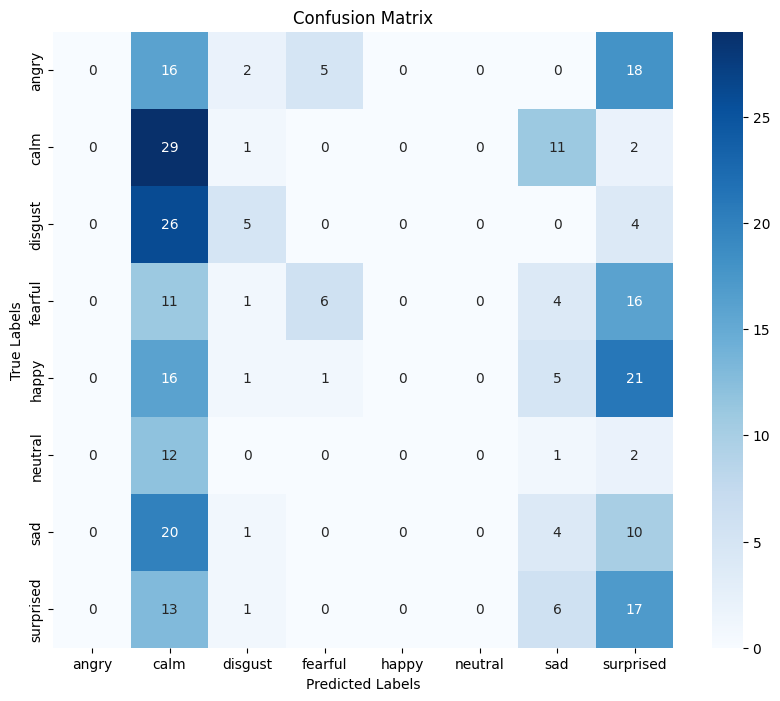

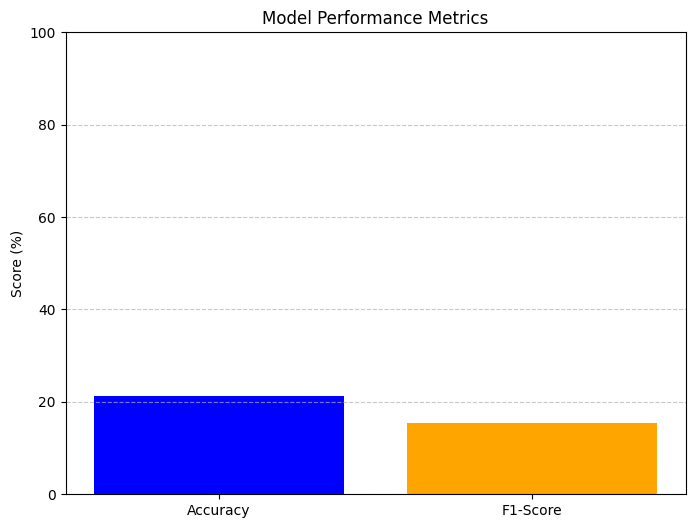

In [10]:
# Initialize model, loss function, and optimizer
num_classes = len(label_encoder.classes_)
model = SERModelImp(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_mel, X_train_combined)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_mel, X_test_combined)
    _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
f1 = f1_score(y_test.cpu().numpy(), y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot metrics
metrics = ["Accuracy", "F1-Score"]
values = [accuracy * 100, f1 * 100]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange'])
plt.title("Model Performance Metrics")
plt.ylabel("Score (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
# Save Model
torch.save(model.state_dict(), "ser_model_imp.pth")